# MMI Optimization with Tidy3D Design Plugin

In this notebook, we present a comprehensive workflow for optimizing photonic components within PhotonForge, utilizing the [Tidy3D Design Plugin](https://www.flexcompute.com/tidy3d/examples/notebooks/Design/) (`tidy3d.plugins.design`). We will specifically focus on designing and optimizing a multimode interference (MMI) splitter component.

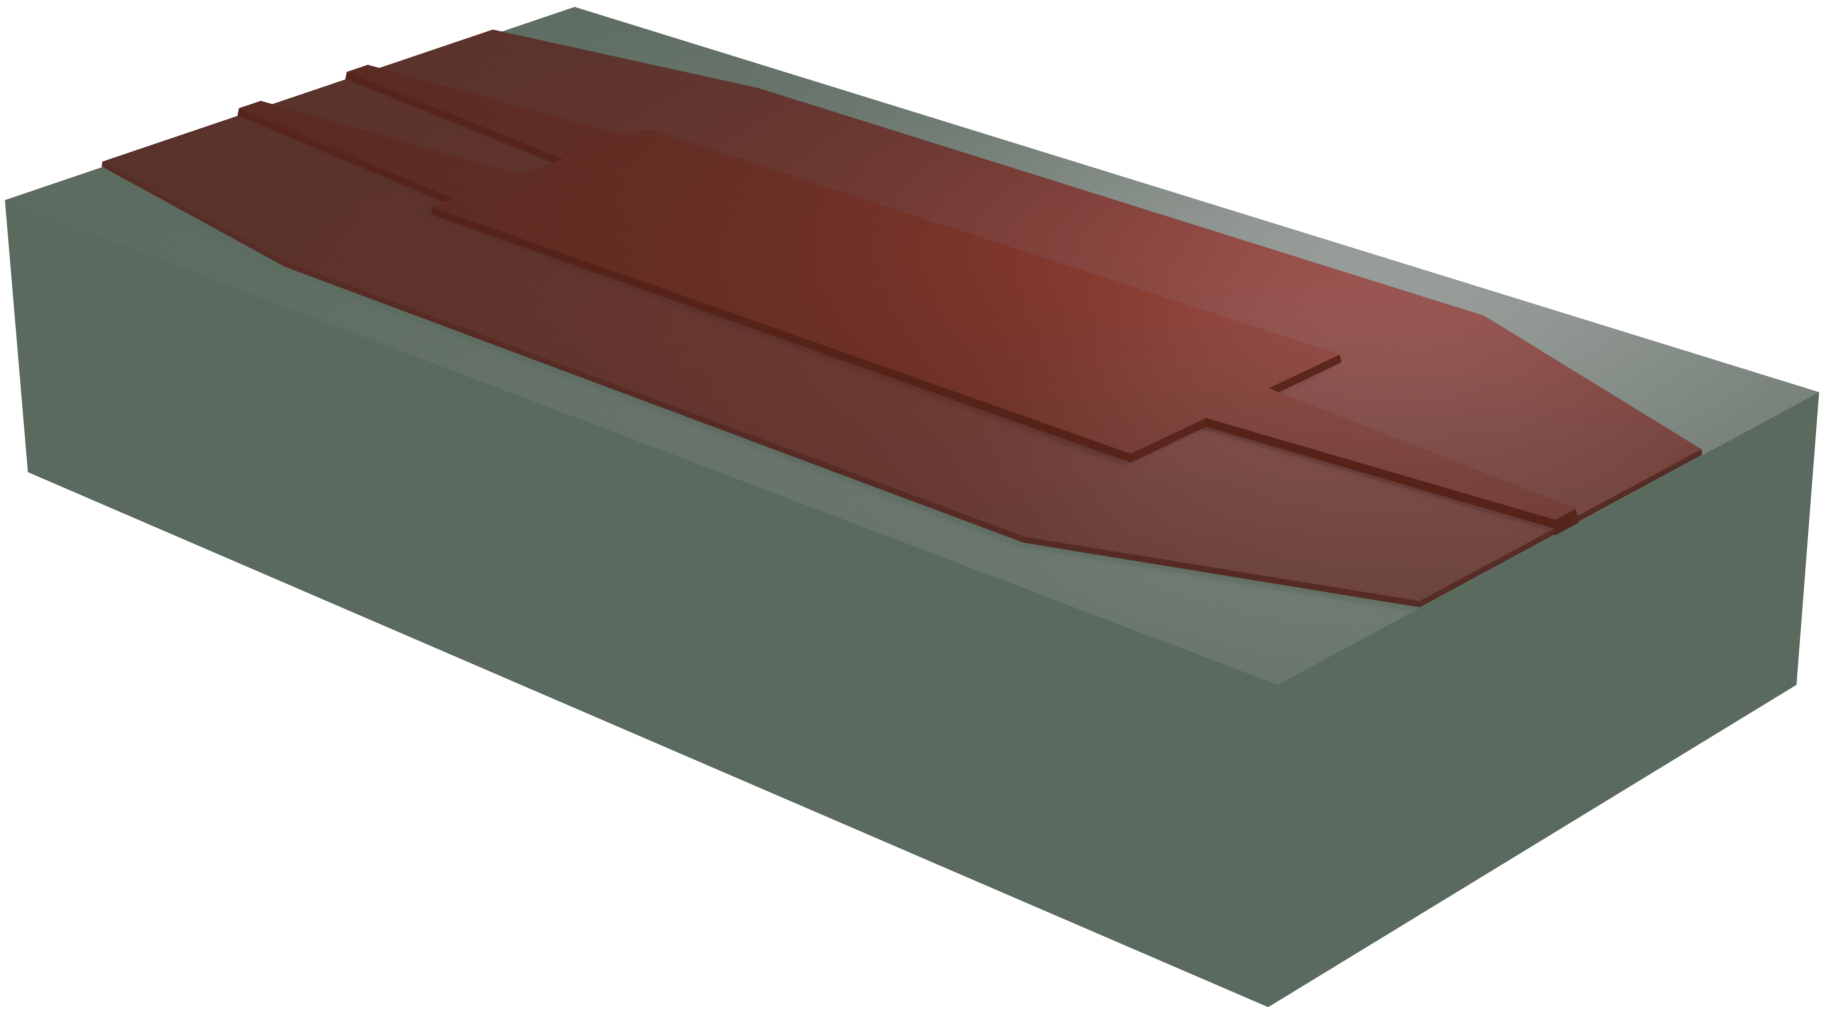

The workflow covers:

- Initializing the Process Design Kit (PDK)
- Designing the photonic component
- Setting up simulations
- Conducting parameter sweeps and Bayesian optimization
- Evaluating optimization results


## Initialize the Process Design Kit (PDK)

We begin by initializing a standard technology stack for the Silicon-on-Insulator (SOI) platform. PhotonForge supports several additional PDKs, including two open-source options: [SiEPIC OpenEBL](https://siepic.ca/openebl/) and [Luxtelligence LNOI400](https://luxtelligence.github.io/lxt_pdk_gf/).  

In this notebook, we use the [SiEPIC OpenEBL technology](../_autosummary/photonforge.Technology.rst), which provides predefined settings for materials, layer thicknesses, and other critical photonic parameters. 


In [1]:
# The Bayesian optimizer uses the bayesian-optimization external package version 1.5.1.
# Uncomment the following line to install the package
# pip install bayesian-optimization==1.5.1

import matplotlib.pyplot as plt
import numpy as np
import photonforge as pf
import siepic_forge as siepic_pdk
import tidy3d as td
import tidy3d.plugins.design as tdd
from photonforge.live_viewer import LiveViewer
from rich.pretty import Pretty

viewer = LiveViewer()

Starting live viewer at http://localhost:5001


Address already in use
Port 5001 is in use by another program. Either identify and stop that program, or start the server with a different port.


Note that the technology stacks in PhotonForge are parametric objects, meaning parameters such as layer thicknesses, material media, sidewall angles, and more can easily be modified according to design requirements. In this notebook, we include the air above the cladding since the cladding is really thin. 

Below is the technology setting and the list of the technology layers. For our design, we'll specifically utilize the "Si" and "Si slab" layers to create a rib-waveguide-based MMI splitter.

We use a [default_mesh_refinement](../config.rst#photonforge.config.default_mesh_refinement) of 12 to decrease simulation time. It is still sufficiently accurate for optimization purpose. We will simulate the final optimal design with the default mesh refinement of 20.

In [2]:
# modified the technology stack to include substreate and air above the cladding
tech = siepic_pdk.ebeam(include_top_opening=True)

# some configuration settings
pf.config.default_technology = tech
pf.config.default_mesh_refinement = 12
td.config.logging_level = "ERROR"

# set wavelength of interest (c-band)
wavelengths = np.linspace(1.53, 1.565, 51)
frequencies = pf.C_0 / wavelengths
tech.layers

Name          Layer    Description    Color    Pattern
--------------------------------------------------------------
Si                    (1, 0)   Waveguides   #ff80a818     \\  
PinRec               (1, 10)   SiEPIC       #00408018     /   
PinRecM              (1, 11)   SiEPIC       #00408018     /   
Si_Litho193nm        (1, 69)   Waveguides   #cc80a818     \   
Waveguide            (1, 99)   Waveguides   #ff80a818     \   
Si slab               (2, 0)   Waveguides   #80a8ff18     /   
SiN                   (4, 0)   Waveguides   #a6cee318     \\  
Oxide open (to BOX)   (6, 0)   Waveguides   #ffae0018     \   
Text                 (10, 0)                #0000ff18     \   
M1_heater            (11, 0)   Metal        #ebc63418     xx  
M2_router            (12, 0)   Metal        #90857018     xx  
M_Open               (13, 0)   Metal        #3471eb18     xx  
Si N                 (20, 0)   Doping       #7000ff18     \\  
Si N++               (24, 0)   Doping       #0000ff18     :   
VC                   (40, 0)   Metal        #3a027f18     xx  
DevRec               (68, 0)   SiEPIC       #00408018   hollow
FbrTgt               (81, 0)   SiEPIC       #00408018     /   
FloorPlan            (99, 0)   Misc         #8000ff18   hollow
SEM                  (200, 0)  Misc         #ff00ff18     \   
Deep Trench          (201, 0)  Misc         #c0c0c018   solid 
Keep out             (202, 0)  Misc         #a0a0c018     //  
Isolation Trench     (203, 0)  Misc         #c0c0c018   solid 
Dicing               (210, 0)  Misc         #a0a0c018   solid 
Chip design area     (290, 0)  Misc         #80005718   hollow
FDTD                 (733, 0)  SiEPIC       #80005718   hollow
BlackBox             (998, 0)  SiEPIC       #00408018   solid 
Errors               (999, 0)  SiEPIC       #00008018     /

In [3]:
Pretty(tech.parametric_kwargs, max_depth=1)

{
    'si_thickness': 0.22,
    'si_slab_thickness': 0.09,
    'sin_thickness': 0.4,
    'si_mask_dilation': 0.0,
    'si_slab_mask_dilation': 0.0,
    'sin_mask_dilation': 0.0,
    'sidewall_angle': 0.0,
    'metal_si_separation': 2.2,
    'router_thickness': 0.6,
    'heater_thickness': 0.2,
    'top_oxide_thickness': 0.3,
    'bottom_oxide_thickness': 3.017,
    'include_top_opening': True,
    'include_substrate': False,
    'sio2': {...},
    'si': {...},
    'sin': {...},
    'router_metal': {...},
    'heater_metal': {...},
    'opening': Medium(...)
}

## Creating a 1x2 MMI Component

Next, we'll create a parametric 1x2 MMI component using PhotonForge. We'll use the [stencils.mmi](../_autosummary/photonforge.stencil.mmi.rst#photonforge.stencil.mmi) method to generate the basic geometry and add this to the core waveguide layer ("Si"). 

To form the rib waveguide structure, we apply the [envelope](../_autosummary/photonforge.envelope.rst) function around the core geometry with an offset defined by the parameter `padding`. This envelope is then added to the "Si slab" layer.

Afterward, ports of type `Rib_TE_1550_500` are automatically identified and assigned using the [detect_ports](../_autosummary/photonforge.Component.rst#photonforge.Component.detect_ports) method. Lastly, we incorporate the [Tidy3DModel](../_autosummary/photonforge.Tidy3DModel.rst) for simulation purposes.


In [4]:
@pf.parametric_component
def mmi_1x2(
    *,
    length=12,
    width=5,
    port_length=6,
    tapered_width=1.5,
    padding=3,
    port_spec=tech.ports["Rib_TE_1550_500"]
):
    """
    Creates a parametric 1x2 multimode interference (MMI) splitter component.

    Parameters:
        length (float): Length of the central MMI region (μm).
        width (float): Width of the central MMI region (μm).
        port_length (float): Length of input/output waveguide ports (μm).
        tapered_width (float): Width at the tapered junction between ports and MMI region (μm).
        padding (float): Padding offset around the core layer to form slab waveguide (μm).
        port_spec (photonforge.PortSpec): Port specifications for this component

    Returns:
        PhotonForge Component: Configured MMI splitter with ports and simulation model.
    """
    if isinstance(port_spec, str):
        port_spec = pf.config.default_technology.ports[port_spec]

    # Create an empty component named "MMI1x2"
    mmi = pf.Component("MMI1x2")

    port_width, _ = port_spec.path_profile_for("Si")

    # Generate the base geometry for the MMI splitter
    mmi_structure = pf.stencil.mmi(
        length=length,
        num_ports=(1, 2),
        width=width,
        port_length=port_length,
        port_width=port_width,
        tapered_width=tapered_width,
    )

    # Add the geometry to the "Si" layer
    mmi.add("Si", *mmi_structure)

    # Create slab structure surrounding the core geometry
    slab_structures = pf.envelope(mmi, offset=padding, trim_x_min=True, trim_x_max=True)

    # Add slab structure to "Si slab" layer
    mmi.add("Si slab", slab_structures)

    # Detect and add ports automatically
    mmi.add_port(mmi.detect_ports([port_spec]))
    assert len(mmi.ports) == 3, "Port detection failed: expected exactly 3 ports."

    # Include the Tidy3D simulation model
    mmi.add_model(pf.Tidy3DModel(port_symmetries=[("P0", "P2", "P1")]), "Tidy3DModel")

    return mmi


# Instantiate the component with custom dimensions
mmi = mmi_1x2(length=15, width=5, port_length=6)
viewer.display(mmi)

## Defining the Figure of Merit (FoM) for MMI Optimization

Next, we define a function to create the MMI splitter component and calculate its figure of merit (FoM). Given that the 1x2 MMI splitter is symmetric, we expect equal transmitted power at both output ports. Therefore, our figure of merit is defined as the average transmitted power at the two output ports across the specified frequency range.

The following function constructs the MMI component, simulates it to obtain the scattering parameters (S-parameters), and calculates the average transmitted power as our optimization metric:


In [5]:
def fom_mmi(
    frequencies=frequencies,
    length=12,
    width=5,
    port_length=6,
    tapered_width=1.5,
    padding=3,
    port_spec=tech.ports["Rib_TE_1550_500"],
):
    # create mmi component
    mmi = mmi_1x2(
        length=length,
        width=width,
        port_length=port_length,
        tapered_width=tapered_width,
        padding=padding,
        port_spec=port_spec,
    )

    # Get the S-matrix object from the MMI component
    s_matrix = mmi.s_matrix(frequencies=frequencies, model_kwargs={"inputs": ["P0"]})

    # Keys: ('P0@0', 'P1@0') is S21, ('P0@0', 'P2@0') is S31.
    # Because of symmetry we only need S21
    S21 = s_matrix["P0@0", "P1@0"]

    # Compute power (|S|^2) for the transmission coefficients over all frequencies
    P21 = np.abs(S21) ** 2

    # Average transmitted power (which is the complement of loss)
    avg_transmitted_power = 2 * np.mean(P21)

    fom_value = avg_transmitted_power
    return fom_value

### Defining Design Parameters

First, we define the key design [parameters](https://www.flexcompute.com/tidy3d/examples/notebooks/Design/#Parameters) that serve as inputs to our previously defined `fom_mmi` function.

In this example, we focus on four critical parameters: `length`, `width`, `tapered_width`, and `port_length`. Each parameter is defined as a named `tdd.ParameterFloat`, with clearly specified spans. The parameter names must match exactly with the argument names of the `fom_mmi` function.

Since we intend to perform parameter sweeps specifically on `port_length` and `tapered_width`, we include the `num_points` parameter to determine the resolution of these sweeps. Note that the `num_points` attribute is only relevant for parameter sweeps and will be ignored during Bayesian optimization.


In [6]:
param_length = tdd.ParameterFloat(name="length", span=(10, 20))
param_width = tdd.ParameterFloat(name="width", span=(4, 6))
param_tapered_width = tdd.ParameterFloat(
    name="tapered_width", span=(1, 2), num_points=3
)
param_port_length = tdd.ParameterFloat(name="port_length", span=(5, 9), num_points=5)

### Defining and Running the Parameter Sweep

Next, we set up and execute a parameter sweep using the Tidy3D Design plugin. We select the `MethodGrid()` method, which performs a structured grid sweep over the specified parameters.

We then create a `DesignSpace`, specifying the parameters (`param_port_length` and `param_tapered_width`) defined earlier, along with the chosen method (`method`). The `path_dir` argument indicates where the simulation data will be stored.

Finally, we execute the parameter sweep by calling the `run()` method of the `DesignSpace` object, passing the previously defined figure-of-merit function `fom_mmi`.


In [7]:
method = tdd.MethodGrid()
design_space = tdd.DesignSpace(
    parameters=[param_port_length, param_tapered_width],
    method=method,
    path_dir="./data",
)
sweep_results = design_space.run(fom_mmi)

Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-FZ7PGAKJRU3BMIJ6IKZD6VCQ5NQIP2OU2XRD3OOIWEG3HYT4KR4A.json.
Progress: 100% 


Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-XM5X43GGP443UKWTAVA5VOCCUH6CDNX5DJCTVSTI4WV3FEH7GFRQ.json.


Progress: 100% 
Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-5N4LI4CL6MSI3JMHDFWFUFYWGUN2X4K42X3QS7CULOOXZYYJFBCQ.json.


Progress: 100% 


Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-UXU3SFLT3MRZXZVULWVKFB3GOEP7RNUA6VK3QPXG66X6P362KJ6Q.json.
Progress: 100% 


Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-722FCTWJBBI4ZRCY6R6EMQ7O5ZPLXJVJOVTAYEFOSOKCSGIB32DQ.json.


Progress: 100% 
Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-CR7B4H7QQKHJOHKLVJ4JZU3RYRIWYTCQGXFXKMVOASC6Q5WUYFVQ.json.


Progress: 100% 


Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-IM5LSF2ZHE7PMF6LMCFQ4VKC6IVMLQBM5UXMIQJFOC55URNLZVZA.json.
Progress: 100% 


Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-NJAWM6IIFRFG5XU62GSW45VNWJQCBGL7WXV6EGMSPFZ3FBOWT33A.json.


Progress: 100% 
Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-KZGWE4UCMKUJUUVUD5P4C72TVZ5AEF4KMLQJ3LJQEJKIQJTRI7ZA.json.


Progress: 100% 


Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-RTYT2FR6KZEUGFX5XNE23H4YHSRSJ2VHCM3CUKD3LGBX2APFIE2A.json.
Progress: 100% 


Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-RKBZFS3KTIH3RAAGI5OGPJXJ5NEIKF5A6W4UIMGMPHFQTI32ACGQ.json.
Progress: 100% 


Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-MS4YR3YEA2YSHJIHSMQOULKESXJB4H5R2GSYNUVKB2SR4VGTYIRA.json.
Progress: 100% 
Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-6HJN2D5G5IU45OBEEHL3AMAW2B74CCEIWIDL6CZHPDJO5X326SOQ.json.


Progress: 100% 
Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-UPGJ4D7Y6UBGE5SHFYKOUF3PAY3DDAMEGJUDLKRKKLXUPJ75X5JQ.json.


Progress: 100% 
Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-G2KYIGEOCJN7CRYWUZON2SHYJ7FEJSELN5CGPZCBC4BJXVHGGYYA.json.
Progress: 100% 



We convert the sweep results into a DataFrame for easy visualization. Below are the first five data points from our parameter sweep:


In [8]:
# The first 5 data points
df = sweep_results.to_dataframe()
df.head()

port_length  tapered_width    output
0          5.0            1.0  0.129265
1          6.0            1.0  0.134282
2          7.0            1.0  0.128875
3          8.0            1.0  0.129686
4          9.0            1.0  0.133221


We visualize the sweep results by plotting the Figure of Merit (FoM) against `port_length` for different values of `tapered_width`. Each curve corresponds to a unique `tapered_width`, clearly showing how this parameter influences the overall performance of the MMI splitter.


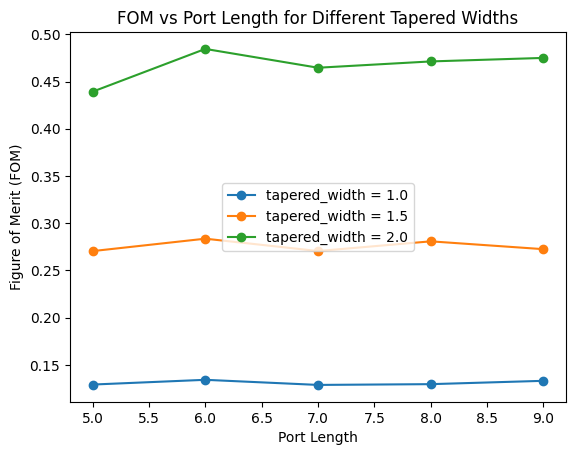

In [9]:
# Create a figure and axis
fig, ax = plt.subplots()

# Loop over the unique tapered_width values and plot each curve
for tw in sorted(df["tapered_width"].unique()):
    # Filter the DataFrame for the current tapered_width value
    df_subset = df[df["tapered_width"] == tw]
    # Sort by port_length for a smoother curve
    df_subset = df_subset.sort_values(by="port_length")

    ax.plot(
        df_subset["port_length"],
        df_subset["output"],
        marker="o",
        label=f"tapered_width = {tw}",
    )

# Set labels and title
ax.set_xlabel("Port Length")
ax.set_ylabel("Figure of Merit (FOM)")
ax.set_title("FOM vs Port Length for Different Tapered Widths")
ax.legend()

# Show the plot
plt.show()

### Performing Bayesian Optimization

Next, we perform Bayesian optimization to efficiently explore the design space and identify optimal parameters. We select the [MethodBayOpt](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.design.MethodBayOpt.html#tidy3d.plugins.design.MethodBayOpt) method, specifying:

- `initial_iter=4`: Number of initial random iterations to explore the design space broadly. This provides a starting point for the Gaussian processor to optimize from.
- `n_iter=6`: Number of additional iterations guided by the Gaussian processor to refine the parameter search.
- `seed=1`: Set the random number generator seed for a reproducible result.

We create a new `DesignSpace`, including the parameters `param_length`, `param_width`, and `param_tapered_width`. We then execute the optimization process by running our defined figure-of-merit function (`fom_mmi`):


In [10]:
method = tdd.MethodBayOpt(initial_iter=4, n_iter=6, seed=1)
design_space = tdd.DesignSpace(
    parameters=[param_length, param_width, param_tapered_width],
    method=method,
    path_dir="./data",
)
optimization_result = design_space.run(fom_mmi, verbose=True)

Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-T4M5NBVWEX6SYAMGR3L5F2JR75VTUHR5ZNQDNONIA63ITLU7QAYA.json.
Progress: 100% 
Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-ZF4QKDTUMSJCTYYW5ZWNNMHAYDSO67OZD7JJOL5NDSY6SKVB753A.json.
Progress: 100% 


Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-X63PI6OIEHKCJQDSNK4BUHRBTH5HRZIAFMLKH3ZCD63LQWZNZXMQ.json.
Progress: 100% 
Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-YAGKHPRP7LK6E6765ELFBMOOGBEZCVX3IC3PCJA7B7WNGL7MOLAQ.json.
Progress: 100% 


12:29:15 -03 Best Fit from Initial Solutions: 0.986                             
             

Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-AEWNMVYFN5GRI3CHM75AZ4PISJ6EXK5MSYOQBLKVU2KDTTZNKXLA.json.
Progress: 100% 


             Latest Best Fit on Iter 0: 0.989                                   
             

Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-MRR4WP43MN53LPXB5JODIYLMSFAMNGTANOHA62DWCUPESY5PI36A.json.
Progress: 100% 


Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-4BMUOZH5V23VHBO7RHQI5IOWK2EOUWPDUSEP25QWOB2MBQG3K7PA.json.
Progress: 100% 


Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-OCS45RMRX3B5UN7B7V4GMZRANETHURZXY2EAR2IM5WNPIM5RCNQA.json.
Progress: 100% 


Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-KIINUEUE2Q3RK5ELWRX76HKFCV6ARTIHTCZ4HX6BDJDXYNTG6XWQ.json.
Progress: 100% 


Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-BPXCXDQXQAXEVLNLP4ALITPFVYODOX44MDQFELIFLFSNRUSEVMIA.json.
Progress: 100% 


12:29:17 -03 Best Result: 0.9885522764510108                                    
             Best Parameters: length: 13.72659303348194 tapered_width:          
             1.7498143887938291 width: 4.0                                      
             

### Retrieving Optimal Design Parameters

We extract the optimal parameters obtained from the Bayesian optimization. The best parameters are those that maximize our figure of merit (fitness). We print both the best fitness value and the corresponding optimized parameters:


In [11]:
best_params = optimization_result.optimizer.max["params"]
print(f"Best fitness: {optimization_result.optimizer.max['target']}")
print(f"Best parameters: {optimization_result.optimizer.max['params']}")

Best fitness: 0.9885522764510108
Best parameters: {'length': np.float64(13.72659303348194), 'tapered_width': np.float64(1.7498143887938291), 'width': np.float64(4.0)}


Using the optimal parameters obtained from the Bayesian optimization, we construct the optimized MMI splitter component. Then, we compute its scattering matrix (S-matrix) across the specified frequency range and visualize the transmission results as a function of wavelength. We perform final simulation with the default mesh refinement value of 20, to make sure that the results are accurate. The loss of the device is less than 0.075 dB over the whole bandwidth, which is impressive.


Loading cached simulation from .tidy3d/pf_cache/XVO/fdtd_info-QPWUC4T6H2ELJYHHVN6GTFI3SWFKVGLGLXELQUAWVTUGIBYVQ4AQ.json.
Progress: 100% 


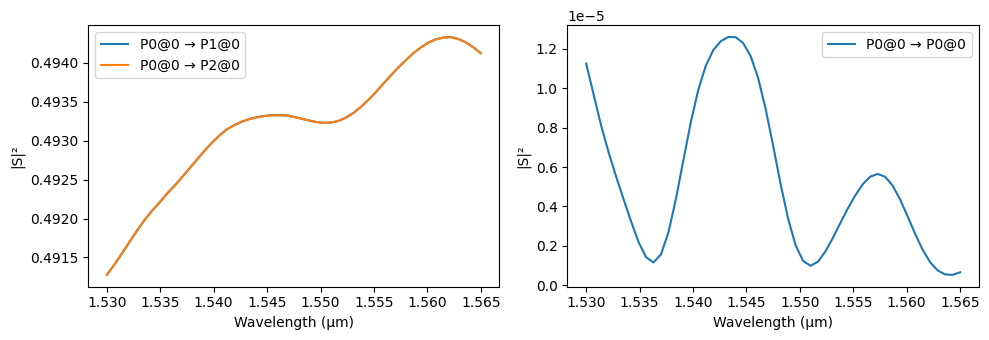

In [12]:
pf.config.default_mesh_refinement = 20
mmi = mmi_1x2(**best_params)

# Get the S-matrix object from the optimized MMI component and plot the results
s_matrix = mmi.s_matrix(frequencies=frequencies, model_kwargs={"inputs": ["P0"]})
ax = pf.plot_s_matrix(s_matrix, x="wavelength")